# 효율적 경계선 Part III - 최적화 모듈

자산이 2개 이상인 포트폴리오의 효율적 경계선을 생성하기 위해서는 효율적 경계선 상의 포트폴리오 가중치를 찾아야 합니다.

우선 2개의 자산 케이스 때 이미 생성한 것과 동일한 종류의 함수를 생성하는 것으로 시작해보겠습니다.

```python

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = ???? # we need to implement: optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

평소와 같이 데이터를 로드합니다.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import port_opt_toolkit as potk

ind = potk.get_ind_returns()
er = potk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

최적의 가중치를 찾기 위해서는 주어진 수익률 수준에서 최소 변동성을 찾아줄 수 있는 함수가 필요합니다.

```python
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```

위의 함수를 사용하여 'Games'와 'Fin' 간의 2개 자산에 대한 최적화를 진행하고 이를 통해 얻은 결과를 재현해 보겠습니다. 지난 시간에 했던 것처럼 효율적 경계선을 그려보겠습니다.

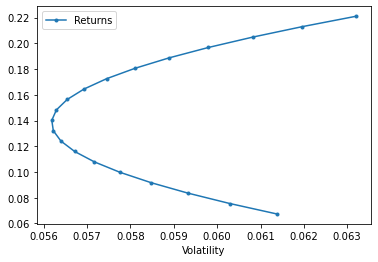

In [3]:
l = ["Games", "Fin"]
potk.plot_ef2(20, er[l], cov.loc[l,l])

목표 수익률이 0.15인 포트폴리오의 Efficient Frontier는 약 0.056이므로 최적화 프로그램이 이를 찾을 수 있는지 확인해보겠습니다.

In [4]:
weights_15 = potk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = potk.portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.05633270209126173

완벽합니다!

이제 우리는 목표 수익률이 주어진 경우 변동성을 최소화하기 위한 가중치를 찾을 수 있습니다. 그렇기 때문에 이제는 수익률의 범위를 격자로 나누어 각각의 격자점에서 최소 변동성을 목표로 하는 포트폴리오를 찾아 마침내 효율적 경계선을 그릴 수 있습니다.

아래의 두 가지 함수를 모듈에 추가합니다.

```python
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

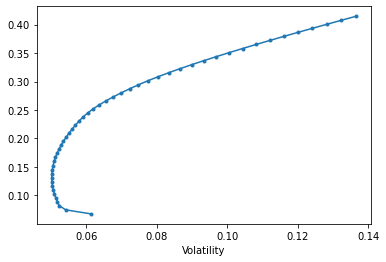

In [5]:
l = ["Smoke", "Fin", "Games", "Coal"]
potk.plot_ef(50, er[l], cov.loc[l,l])

포트폴리오의 효율적 경계선이 완성되었습니다.